### State Space Discretization

From the previous notebook you probably end up thinking about the fact that the states and action we were dealing with on the Frozen Lake environment were discrete. It should upset you a bit, there is really not much we can do with that? 

But worry-not! This notebook will relax that constraint. We will look at what to do when the state space is continuous. We will keep actions discrete, but that's OK. For now, we'll look at a very simple way of dealing with continuous states.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tempfile
import base64
import pprint
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

#### Q-Learning

In the world we will be looking into this time, the Cart Pole example, we have 4 continous values to represent a state. An X position, change in X, acceleration and change in acceleration.

Let's take a peek at a single observation:

In [4]:
env = gym.make('CartPole-v0')
observation = env.reset()
actions = env.action_space
env.close()
print(observation)
print(actions)

[2017-04-26 16:22:50,371] Making new env: CartPole-v0


[-0.03106447  0.02174884 -0.02941032 -0.0195286 ]
Discrete(2)


Just as expected, a combination of 4 continuous variables make a state, and 2 discrete actions. Hmm, what to do? The actions are sort of the same as before, but the states are definitely different. We can't just create a Q table anymore...

Let's look a little more into the the possible values these variables can take. We will explore for 100 episodes just to collect some sample data. You can see I force the algorithm to take the action 1 and action 0 for several consecutive timesteps. This is to make sure we explore the entire space and not just random. If we do random actions the cart would just jitter on the same place and the x axis would not get explored much. Stay with me, I'll show you.

In [10]:
observations = []
for episode in range(1000):
    observation = env.reset()
    for t in range(100):
        env.render()
        observations.append(observation)
        action = env.action_space.sample()
        if episode < 25:
            action = 1
        elif episode < 50:
            action = 0
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()
x_vals = np.array(observations)[:,0]
xd_vals = np.array(observations)[:,1]
a_vals = np.array(observations)[:,2]
ad_vals = np.array(observations)[:,3]
y = np.zeros_like(x_vals)

Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 11 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 11 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode 

Let's visualize the values that each of the variables can take:

(-0.15, 0.15)

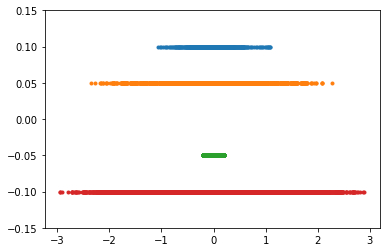

In [12]:
plt.plot(x_vals, y + 0.10, '.')
plt.plot(xd_vals, y + 0.05, '.')
plt.plot(a_vals, y - 0.05, '.')
plt.plot(ad_vals, y - 0.10, '.')

plt.ylim([-0.15, 0.15])

See? The x values seem to go from -1 to 1, changes in x from -2 to 2, etc.

In fact, we can get the exact values from the `env`, although you could just sample a bunch of episodes and find out the limits yourself. Let's use the environments to keep focus.

In [13]:
x_thres = ((env.env.observation_space.low/2)[0],
           (env.env.observation_space.high/2)[0])
a_thres = ((env.env.observation_space.low/2)[2],
           (env.env.observation_space.high/2)[2])

In [14]:
print(x_thres, a_thres)

(-2.3999999999999999, 2.3999999999999999) (-0.20943951023931953, 0.20943951023931953)


Not exactly the same as we thought. Can you think why? And, how to explore the state space throughout?

Regardless, I will move forward trying to solve this environment. What we have above is good enough because it gives us the most commonly sampled observations for each of the variables. Cutting through these and boxing them is a process called discretization. It is basically a way to convert from continuous states to discrete. This would let us deal with the continous states nicely.

Let's try it.

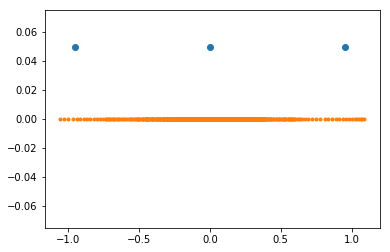

In [16]:
x1 = np.linspace(x_thres[0] + .5, x_thres[1] - .5, 
                 4, endpoint=False)[1:]
y1 = np.zeros(len(x1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(x1, y1, 'o')
plt.plot(x_vals, y, '.')

I'm creating 4 states, anything left/right of each of the dots represent a unique state.

Let's do the same for the variable 'change in x' or xd:

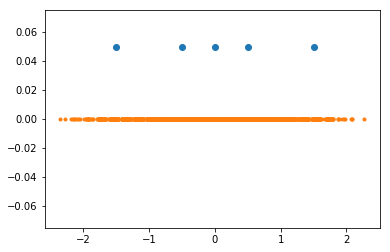

In [17]:
xd1 = np.sort(np.append(np.linspace(-1.5, 1.5, 4, endpoint=True), 0))
y1 = np.zeros(len(xd1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(xd1, y1, 'o')
plt.plot(xd_vals, y, '.')

And for the acceleration variable:

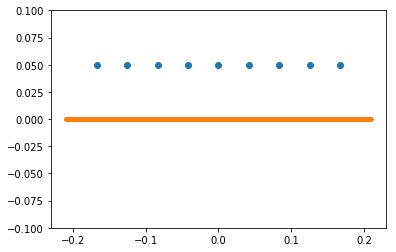

In [18]:
a1 = np.sort(np.linspace(a_thres[0], a_thres[1],
                         10, endpoint=False)[1:])
y1 = np.zeros(len(a1)) + 0.05

plt.ylim([-0.1, 0.1])
plt.plot(a1, y1, 'o')
plt.plot(a_vals, y, '.')

Finally, the 'change in acceleration':

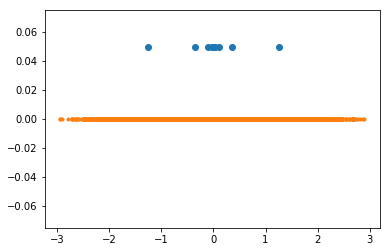

In [20]:
all_vals = np.sort(np.append(
    (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
    -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
ad1 = all_vals[idxs]
y1 = np.zeros(len(ad1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(ad1, y1, 'o')
plt.plot(ad_vals, y, '.')

Now, we use a function called 'digitize' which basically creates the buckets as mentioned above.

In [21]:
a1

array([-0.16755161, -0.12566371, -0.0837758 , -0.0418879 ,  0.        ,
        0.0418879 ,  0.0837758 ,  0.12566371,  0.16755161])

For example, look at the acceleration variable. We go from -0.16 to 0.16 with equally spaced chunks. What would you expect a value of -0.99 fall into? Which bucket?

In [22]:
np.digitize(-0.99, a1)

array(0)

Right. Bucket 0. How about a value of 0. If -0.99, which is less than -0.16 (the first bucket) falls into the first bucket, what do you think 0 would fall into?

In [23]:
np.digitize(0, a1)

array(5)

That was actually a tricky question. Digitize default to the 'left' if the value is equal to any of the buckets. How about a value slightly less than zero then? What bucket do you call? 

In [24]:
np.digitize(-0.0001, a1)

array(4)

Right, 4 it is, how about a number slightly more than zero?

In [25]:
np.digitize(0.0001, a1)

array(5)

Back to 5.

Cool!!

Let's look at the buckets next to each of the variables.

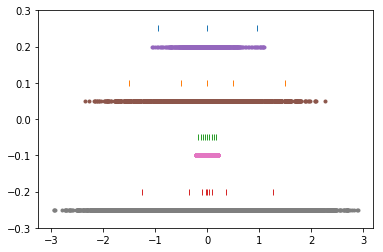

In [26]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.ylim([-0.3, 0.3])

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')

Nice, how about we add the lower and upper boundaries we got before?

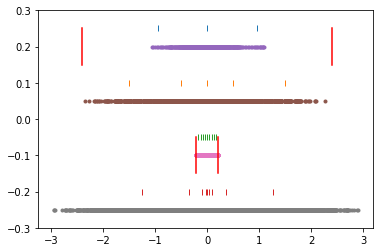

In [28]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')


plt.ylim([-0.3, 0.3])

plt.plot((x_thres[0], x_thres[0]), (0.15, 0.25), 'k-', color='red')
plt.plot((x_thres[1], x_thres[1]), (0.15, 0.25), 'k-', color='red')
plt.plot((a_thres[0], a_thres[0]), (-0.05, -0.15), 'k-', color='red')
plt.plot((a_thres[1], a_thres[1]), (-0.05, -0.15), 'k-', color='red')

Nice, you might not agree with the buckets I selected. That is OK, in fact I hope you don't, there seems to be a better way of manually selecting these buckets. You will get a chance at improving on this later.

Let me give you a couple of functions that would make our algorithm work.

In [29]:
def learning_schedule(episode, n_episodes):
    return max(0., min(0.8, 1 - episode/n_episodes))

Learning schedule is similar to what `action_selection` did for our previous notebooks. This time we are doing it with the `alpha` which is the learning rate and determines the importance and weight we give to newly calculated values in comparison with values we calculated in ealier iterations. Think about it like how much you trust your past knowledge. Intuitively, early in the exploration phase we don't know much of the environment, so perhaps that is an indication that we should rely on our previous calculation that much. But the more experience, the more should hold onto your knowledge. Now, remember this is also a 'dilemma' meaning there is a tradeoff and there is not a clear cut answer.

Let's continue. We define `action_selection` just as before:

In [30]:
def action_selection(state, Q, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    if np.random.random() < epsilon:
        action = np.random.randint(Q.shape[1])
    else:
        action = np.argmax(Q[state])
    return action, epsilon

And this function, `observation_to_state` will take care of the discretazition. It will input a tuple of continuous values and give us an integer. Let's take a look:

In [31]:
def observation_to_state(observation, bins):
    ss = []
    for i in range(len(observation)):
        ss.append(int(np.digitize(observation[i], bins=bins[i])))
    state = int("".join(map(lambda feature: str(int(feature)), ss)))
    return state

In [36]:
sample_states = [[0.33, 0.2, 0.1, 0.], 
                 [-0.33, 0.2, 0.1, 0.], 
                 [0.33, -0.2, 0.1, 0.], 
                 [0.33, 0.2, -0.1, 0.], 
                 [0.33, 0.2, 0.1, .99]]
for sample_state in sample_states:
    print(observation_to_state(sample_state, (x1, xd1, a1, ad1)))

2375
1375
2275
2325
2378


Cool, right?

Alright, I'll give you the new q_learning algorithm.

In [37]:
def q_learning(env, bins, gamma = 0.99):
    nS = 10 * 10 * 10 * 10
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) - 0.5
    n_episodes = 5000
    
    alphas = []
    epsilons = []
    states = []
    actions = []
    for episode in range(n_episodes):
        observation = env.reset()
        state = observation_to_state(observation, bins)
    
        done = False
        while not done:
            states.append(state)
            
            action, epsilon = action_selection(state, Q, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            observation, reward, done, info = env.step(action)
            nstate = observation_to_state(observation, bins)
            
            alpha = learning_schedule(episode, n_episodes)
            alphas.append(alpha)
            
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q, (alphas, epsilons, states, actions)

You can see it, just like we did before, only differences are the use of the functions defined above and the collection of the alphas, epsilons, etc. This latter one is just to show you some stats and graphs, you could remove them and it would do just as well.

Let's run this algorithm?! Shall we?

In [38]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q, stats = q_learning(env, (x1, xd1, a1, ad1))

[2017-04-26 16:54:26,629] Making new env: CartPole-v0
[2017-04-26 16:54:26,632] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000000.mp4
[2017-04-26 16:54:28,856] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000001.mp4
[2017-04-26 16:54:29,111] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000008.mp4
[2017-04-26 16:54:29,302] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000027.mp4
[2017-04-26 16:54:29,482] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000064.mp4
[2017-04-26 16:54:29,648] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000125.mp4
[2017-04-26 16:54:29,846] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.video000216.mp4
[2017-04-26 16:54:30,131] Starting new video recorder writing to /tmp/tmpqn4_aye8/openaigym.video.0.114.vi

Now, let's take a look at some of the episodes:

In [43]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

Interesting right?

The last episode should show how the agent 'knows' what the goal of the environment, but perhaps not an impressive performance.

Let's look into the value function and policy:

In [44]:
V = np.max(Q, axis=1)
V

array([  0.47535795,  14.03615681,  17.11912036, ...,  -0.04913746,
         0.16842233,   0.49941368])

In [45]:
V.max()

88.554472947818169

In [46]:
pi = np.argmax(Q, axis=1)
pi

array([0, 0, 0, ..., 0, 1, 0])

So, policy looks pretty much the same they looked before. This is because we "made" this environment discrete. Hold your thoughts...

Let's close this environment and see how the agent did per OpenAI Gym.

In [25]:
env.close()

[2017-04-02 21:58:51,167] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpvdek3zuv')


In [26]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-02 21:58:51,190] [CartPole-v0] Uploading 5000 episodes of training data
[2017-04-02 21:58:52,419] [CartPole-v0] Uploading videos of 14 training episodes (57206 bytes)
[2017-04-02 21:58:52,692] [CartPole-v0] Creating evaluation object from /tmp/tmpvdek3zuv with learning curve and training video
[2017-04-02 21:58:53,054] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_AhsiLjLyTDO1gwgnApVzpQ

****************************************************


Not thaaaat well. The agent should have shown learning, but very likely it did not pass the environment. In other words, it learned, but definitely not a solid enough policy.

Let's look at some of the things collected.

In [47]:
alphas, epsilons, states, actions = stats

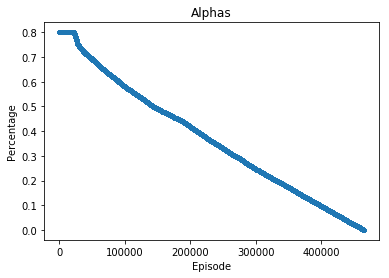

In [53]:
plt.plot(np.arange(len(alphas)), alphas, '.')
plt.title('Alphas')
plt.xlabel('Episode')
plt.ylabel('Percentage')

See the learning rate goes from 0.8 to 0? Alright.

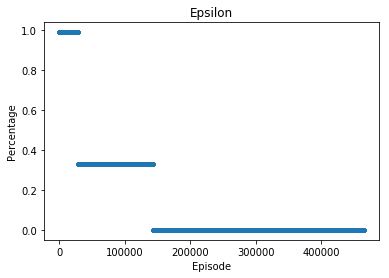

In [54]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')
plt.title('Epsilon')
plt.xlabel('Episode')
plt.ylabel('Percentage')

Interesting exploration style. We force 100% exploration for few episodes, then to ~30% and then become greedy at about 150,000 episodes. Not bad. Could we do better?

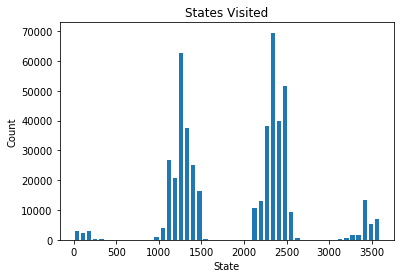

In [55]:
hist, bins = np.histogram(states, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title('States Visited')
plt.xlabel('State')
plt.ylabel('Count')

See some states not visited? That's a by product of the way we discretized the state space, it should not be a problem unless we have a very very large state space after discretization. Then, it might be beneficial tighting things up.

How about the actions?

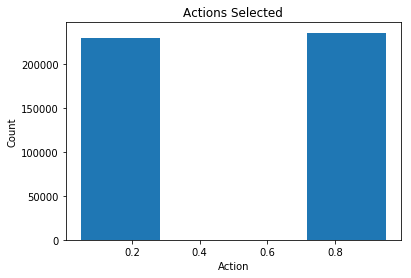

In [56]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.title('Actions Selected')
plt.xlabel('Action')
plt.ylabel('Count')

Expected, I would say. If you want to balance a pole you will have to go left and right to keep the pole in place.

Ok, so from these figures you should think about ways to make this algorithm work. Why things didn't work?? How can we make it learn more or better?

I'll let you explore from now on...

### Your turn

(-0.15, 0.15)

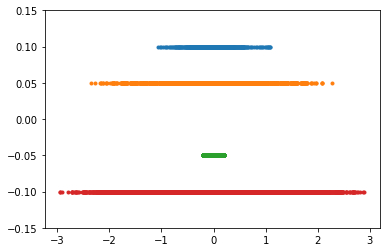

In [57]:
plt.plot(x_vals, y + 0.10, '.')
plt.plot(xd_vals, y + 0.05, '.')
plt.plot(a_vals, y - 0.05, '.')
plt.plot(ad_vals, y - 0.10, '.')

plt.ylim([-0.15, 0.15])

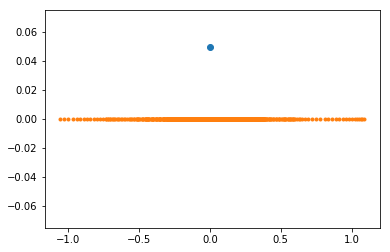

In [58]:
x1 = np.linspace(x_thres[0] + .5, x_thres[1] - .5, 
                 2, endpoint=False)[1:]
y1 = np.zeros(len(x1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(x1, y1, 'o')
plt.plot(x_vals, y, '.')

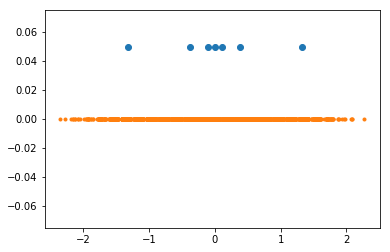

In [59]:
all_vals = np.sort(np.append(
    (np.logspace(-5, 4, 5, endpoint=False, base=2)[1:],
    -np.logspace(-5, 4, 5, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
xd1 = all_vals[idxs]
y1 = np.zeros(len(xd1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(xd1, y1, 'o')
plt.plot(xd_vals, y, '.')

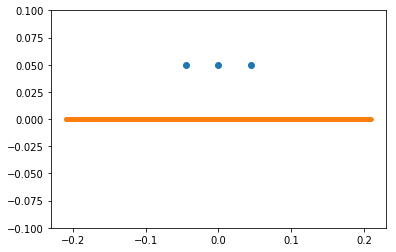

In [60]:
all_vals = np.sort(np.append(
    (np.logspace(-6, 0.01, 4, endpoint=False, base=2)[1:],
    -np.logspace(-6, 0.01, 4, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < a_thres[1] - 0.1)
a1 = all_vals[idxs]
y1 = np.zeros(len(a1)) + 0.05

plt.ylim([-0.1, 0.1])
plt.plot(a1, y1, 'o')
plt.plot(a_vals, y, '.')

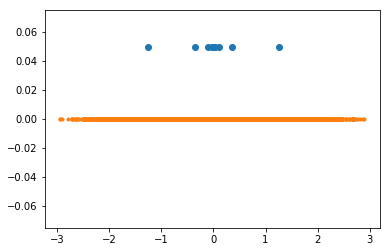

In [61]:
all_vals = np.sort(np.append(
    (np.logspace(-7, 4, 6, endpoint=False, base=2)[1:],
    -np.logspace(-7, 4, 6, endpoint=False, base=2)[1:]), 0))
idxs = np.where(np.abs(all_vals) < 2)
ad1 = all_vals[idxs]
y1 = np.zeros(len(ad1)) + 0.05

plt.ylim([-0.075, 0.075])
plt.plot(ad1, y1, 'o')
plt.plot(ad_vals, y, '.')

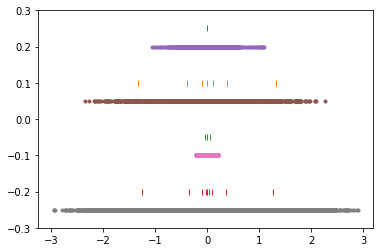

In [62]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.ylim([-0.3, 0.3])

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')

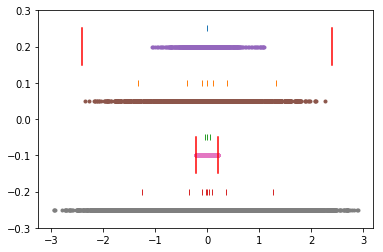

In [63]:
yx1 = np.zeros_like(x1) + 0.25
yx = np.zeros_like(x_vals) + 0.20
yxd1 = np.zeros_like(xd1) + 0.10
yxd = np.zeros_like(xd_vals) + 0.05
ya1 = np.zeros_like(a1) - 0.05
ya = np.zeros_like(a_vals) - 0.10
yad1 = np.zeros_like(ad1) - 0.20
yad = np.zeros_like(ad_vals) - 0.25

plt.plot(x1, yx1, '|')
plt.plot(xd1, yxd1, '|')
plt.plot(a1, ya1, '|')
plt.plot(ad1, yad1, '|')

plt.plot(x_vals, yx, '.')
plt.plot(xd_vals, yxd, '.')
plt.plot(a_vals, ya, '.')
plt.plot(ad_vals, yad, '.')


plt.ylim([-0.3, 0.3])

plt.plot((x_thres[0], x_thres[0]), (0.15, 0.25), 'k-', color='red')
plt.plot((x_thres[1], x_thres[1]), (0.15, 0.25), 'k-', color='red')
plt.plot((a_thres[0], a_thres[0]), (-0.05, -0.15), 'k-', color='red')
plt.plot((a_thres[1], a_thres[1]), (-0.05, -0.15), 'k-', color='red')

In [64]:
def learning_schedule(episode, n_episodes):
    return max(0., min(0.8, 1 - episode/n_episodes))

In [65]:
def action_selection(state, Q, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    if np.random.random() < epsilon:
        action = np.random.randint(Q.shape[1])
    else:
        action = np.argmax(Q[state])
    return action, epsilon

In [66]:
def observation_to_state(observation, bins):
    ss = []
    for i in range(len(observation)):
        ss.append(int(np.digitize(observation[i], bins=bins[i])))
    state = int("".join(map(lambda feature: str(int(feature)), ss)))
    return state

In [67]:
def q_learning(env, bins, gamma = 0.99):
    nS = 10 * 10 * 10 * 10
    nA = env.env.action_space.n
    
    Q = np.random.random((nS, nA)) - 0.5
    n_episodes = 5000
    
    alphas = []
    epsilons = []
    states = []
    actions = []
    for episode in range(n_episodes):
        observation = env.reset()
        state = observation_to_state(observation, bins)
    
        done = False
        while not done:
            states.append(state)
            
            action, epsilon = action_selection(state, Q, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            observation, reward, done, info = env.step(action)
            nstate = observation_to_state(observation, bins)
            
            alpha = learning_schedule(episode, n_episodes)
            alphas.append(alpha)
            
            Q[state][action] += alpha * (reward + gamma * Q[nstate].max() * (not done) - Q[state][action])
            state = nstate
    return Q, (alphas, epsilons, states, actions)

In [68]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

Q, stats = q_learning(env, (x1, xd1, a1, ad1))

[2017-04-26 17:15:05,792] Making new env: CartPole-v0
[2017-04-26 17:15:05,813] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpqn4_aye8')
[2017-04-26 17:15:05,817] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.114.video000000.mp4
[2017-04-26 17:15:06,013] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.114.video000001.mp4
[2017-04-26 17:15:06,227] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.114.video000008.mp4
[2017-04-26 17:15:06,561] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.114.video000027.mp4
[2017-04-26 17:15:06,708] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.114.video000064.mp4
[2017-04-26 17:15:06,874] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.114.video000125.mp4
[2017-04-26 17:15:07,266] Starting new video recorder writing to /tmp/tmplxfovf67/openaigym.video.1.1

In [69]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [70]:
V = np.max(Q, axis=1)
V

array([  0.39549677,  22.40875019,  62.39175886, ...,   0.4135339 ,
         0.22957031,  -0.11561215])

In [71]:
V.max()

95.175029734326586

In [72]:
pi = np.argmax(Q, axis=1)
pi

array([0, 1, 0, ..., 1, 1, 1])

In [73]:
env.close()

[2017-04-26 17:15:29,221] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmplxfovf67')


In [49]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-02 21:59:30,177] [CartPole-v0] Uploading 5000 episodes of training data
[2017-04-02 21:59:31,154] [CartPole-v0] Uploading videos of 14 training episodes (72394 bytes)
[2017-04-02 21:59:32,376] [CartPole-v0] Creating evaluation object from /tmp/tmpmkwghiu4 with learning curve and training video
[2017-04-02 21:59:32,582] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_GDMU3XnQxi3N0vnynQNbg

****************************************************


In [74]:
alphas, epsilons, states, actions = stats

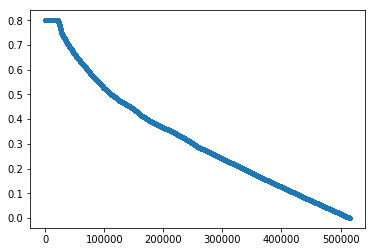

In [75]:
plt.plot(np.arange(len(alphas)), alphas, '.')

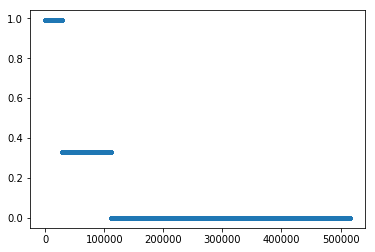

In [76]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')

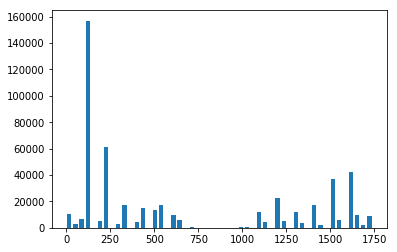

In [77]:
hist, bins = np.histogram(states, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

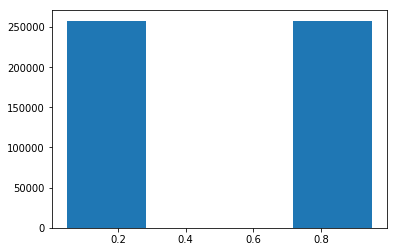

In [78]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

So, how did you do??? Were you able to pass the environment??

If you didn't do not worry, go take a look at the solution notebook. Mine wasn't perfect, but it should consistently pass the environment, which is good. The thing is, this thing of discretizing the state space can get old very quickly. Are you OK with doing some data analysis and manually tell the agent what to look for? Yeah, I didn't think so. That's what Machine Learning and Function Approximation is for!!! Why not use it?

In the next notebook we will look into the same cart pole environment, but guess what, we will use a Neural Network to lear the environment. Now, this is not the DQN algorithm because we will not be feeding it raw images, but the concept should be very similar.

Are you ready for Function Approximators? Deep Reinforcement Learning is a step away.